In [48]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd  
import time

newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}

plt.rcParams.update(newparams)
%matplotlib inline

In [49]:
# Helper functions to use throughout the project

def Matrix_Plot(Mat, size=4, cMap='viridis'):
    '''
    Function to plot a matrix with a colorbar
    '''
    fig = plt.figure(figsize=(size,size))
    ax = plt.axes()
    im = plt.imshow(Mat, cmap=cMap)
    # Create new axes according to image position
    cax = fig.add_axes([ax.get_position().x1+0.01,
                        ax.get_position().y0,
                        0.02,
                        ax.get_position().height])
    plt.colorbar(im, cax=cax)
    plt.show()

def plot_comparison(U_cords, U_Exact, x_cords, y_cords, viewAngle = 300):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15), subplot_kw={"projection": "3d"})
    ax[0].plot_trisurf(x_cords, y_cords, U_cords,
                    cmap='coolwarm', edgecolor='none');
    ax[0].view_init(azim=viewAngle)         # Rotate the figure
    ax[0].set_title('Numerical Solution')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set_zlabel('T')

    ax[1].plot_trisurf(x_cords, y_cords, U_Exact,
                    cmap='coolwarm', edgecolor='none');
    ax[1].view_init(azim=viewAngle)         # Rotate the figure
    ax[1].set_title('Exact Solution')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].set_zlabel('T')

    ax[2].plot_trisurf(x_cords, y_cords, abs(U_cords-U_Exact),
                    cmap='coolwarm', edgecolor='none');
    ax[2].view_init(azim=viewAngle)         # Rotate the figure
    ax[2].set_title('Error')
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')
    ax[2].set_zlabel('T')
    fig.tight_layout(pad=2.0)
    plt.show()

def convergence(bvp, solver): 
    P = 20
    u_exact = bvp.E
    Hconv = np.zeros(P)
    Emax = np.zeros(P)
    M = 5
    for p in range(P):
        bv = BVP(f=bvp.f,g=bvp.g,r=bvp.r,a=1,M=M, T = bvp.T)
        U, x_cord, y_cord = solver(bv)
        Emax[p] = np.max(np.abs(u_exact(x_cord,y_cord)-U))
        Hconv[p] = x_cord[1]-x_cord[0]
        M += 5#2*M-1
    orderMax = np.polyfit(np.log(Hconv),np.log(Emax),1)[0]

    Rate=np.zeros(np.size(Emax))
    Rate[1:]=np.log10(Emax[1:]/Emax[:-1])/np.log10(Hconv[1:]/Hconv[:-1])
    pd.options.display.float_format = '{:.5f}'.format
    df = pd.DataFrame(data={'h': Hconv, 'Error': Emax ,'Rate':Rate}) 

    plt.figure()
    plt.loglog(Hconv,Emax,'o-', label='p={:.2f} in max norm'.format(orderMax))
    plt.grid('on')
    plt.xlabel('h')
    plt.ylabel('error')
    plt.title(bvp.T)
    plt.legend();
    return df

def plot_comparison_2D(U_cords, U_Exact, x_cords, y_cords, viewAngle = 270):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15), subplot_kw={"projection": "3d"})
    ax[0].plot_trisurf(x_cords, y_cords, U_cords,
                    cmap='coolwarm', edgecolor='none');
    ax[0].view_init(elev=90, azim=viewAngle)#azim=45, roll=15)         # Rotate the figure
    ax[0].set_title('Numerical Solution')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set_zticks([])
    # ax[0].set_zlabel('T')

    ax[1].plot_trisurf(x_cords, y_cords, U_Exact,
                    cmap='coolwarm', edgecolor='none');
    ax[1].view_init(elev=90, azim=viewAngle)         # Rotate the figure
    ax[1].set_title('Exact Solution')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].set_zticks([])
    # ax[1].set_zlabel('T')

    ax[2].plot_trisurf(x_cords, y_cords, abs(U_cords-U_Exact),
                    cmap='coolwarm', edgecolor='none');
    ax[2].view_init(elev=90, azim=viewAngle)         # Rotate the figure
    ax[2].set_title('Error')
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')
    ax[2].set_zticks([])
    # ax[2].set_zlabel('T')
    fig.tight_layout(pad=2.0)
    plt.show()

# Task 1
## Task 1 a)

In [50]:
# Exact solution examples
def u1(x,y):
    return np.sin(np.pi*x)*np.exp(-y)

def u1_xx(x,y): # Second derivative with respect to x, exact solution
    return - np.pi**2 *np.sin(np.pi*x)*np.exp(-y)

def u1_xy(x,y): # Mixed derivative with respect to x and y, exact solution
    return -np.pi*np.cos(np.pi*x)*np.exp(-y)

def u1_yy(x,y): # Second derivative with respect to y, exact solution
    return np.sin(np.pi*x)*np.exp(-y)

def f1(x,y, BVP): # RHS 
    return -( (BVP.a+1)*u1_xx(x,y) + 2*BVP.r*u1_xy(x,y) + BVP.r**2 *u1_yy(x,y) )

def g1(x,y): # Boundary conditions
    return u1(x,y)



# Exact soliution 2
def u2(x,y):
    return np.sin(np.pi*x)+np.cos(2*np.pi*y)

def u2_xx(x,y):
    return - np.pi**2 *np.sin(np.pi*x)

def u2_xy(x,y):
    return 0

def u2_yy(x,y):
    return -4*np.pi**2 *np.cos(2*np.pi*y)

def f2(x,y, BVP):
    return -( (BVP.a+1)*u2_xx(x,y) + 2*BVP.r*u2_xy(x,y) + BVP.r**2 *u2_yy(x,y) )

def g2(x,y):
    return u2(x,y)

In [51]:
class BVP(object): 
    def __init__(self, f=0, g=0, r=1, a=1, M=10, E=0, T="BVP"):
        self.f = f # Right hand side (function)
        self.g = g # Boundary conditions (function)
        self.r = r # Value of r
        self.a = a # A strictly positive constant
        self.M = M # Number of subdivision along x-axis (total number of points, including boundaries)
        self.E = E # Exact solution (function)
        self.T = T # Title of the problem

In [52]:
def scheme1a(BVP):
    '''
    Solves the BVP
    We define the number of interior points as (M-1)^2, and all points as (M+1)^2
    The function creates the "tridiagonal" matrix B (with some removed elements) and solves the linear system BU = f + g
    This is a "brute force" implementation of the scheme, where we check for each point if it touches the boundary
    '''

    h = 1/BVP.M # Step size

    # Defining omega domain, including the boundary points
    x_arr = np.linspace(0,1,BVP.M+1) 
    y_arr = np.linspace(0,1,BVP.M+1)

    X, Y = np.meshgrid(x_arr[1:-1],y_arr[1:-1]) # Creating the meshgrid for the interior points

    X_flat, Y_flat = X.flatten(), Y.flatten() # Flattening the meshgrid for further computations

    f_vec = np.zeros((BVP.M-1)**2) # Initializing the vector for the right hand side
    g_vec = np.zeros((BVP.M-1)**2) # Initializing the vector for the boundary conditions

    f_vec += BVP.f(X_flat,Y_flat, BVP) # Computing the right hand side

    tol = 1e-10 # Tolerance for the boundary points
    
    U = np.zeros(((BVP.M+1), (BVP.M+1))) # Initializing the solution matrix, including the boundary points
    U[:,0] = BVP.g(x_arr,0) # Applying the boundary conditions, left boundary
    U[:,-1] = BVP.g(x_arr,1) # Applying the boundary conditions, right boundary
    U[0,:] = BVP.g(0,y_arr) # Applying the boundary conditions, lower boundary
    U[-1,:] = BVP.g(1,y_arr) # Applying the boundary conditions, upper boundary

    dim = (BVP.M-1)**2 # Dimension of the matrix, number of interior points

    B = np.zeros((dim,dim)) # Initializing the matrix for the interior points, one row for each interior point

    X_flat_copy = np.copy(X_flat)
    Y_flat_copy = np.copy(Y_flat)
    
    for i, (X_flat,Y_flat) in enumerate(zip(X_flat,Y_flat)): # Looping over the interior points

        B[i,i] = (2.0*BVP.a)/h**2 + 2/h**2 # Diagonal element, value from the scheme
        
        # Check if the stencil touches the left boundary
        if (math.isclose(X_flat-h,0., abs_tol = tol)):
            
            B[i,i+1] = -BVP.a/h**2 # Element to the right 
            g_vec[i] += BVP.a*BVP.g(X_flat-h,Y_flat)/h**2 + BVP.g(X_flat-h,Y_flat-h)/h**2 # Applying the boundary conditions
            
            # Check it the stencil also touches the upper boundary
            if (math.isclose(Y_flat+h,1., abs_tol = tol)):        
                g_vec[i] += BVP.g(X_flat+h,Y_flat+h)/h**2
            else:
                B[i,i+BVP.M] = -1.0/h**2
                
        # Check if the stencil touches the right boundary
        elif (math.isclose(X_flat+h,1., abs_tol = tol)):
            B[i,i-1] = -BVP.a/h**2
            g_vec[i] += BVP.a*BVP.g(X_flat+h,Y_flat)/h**2 + BVP.g(X_flat+h,Y_flat+h)/h**2
                
            
            # Check if the stencil also touches the lower boundary
            if (math.isclose(Y_flat-h,0., abs_tol = tol)):

                g_vec[i] += BVP.g(X_flat-h,Y_flat-h)/h**2
            else:
                B[i,i-(BVP.M)] = -1.0/h**2

        else:  
            # Check if the stencil touches the upper boundary
            if (math.isclose(Y_flat+h,1., abs_tol = tol)):
                B[i,i-(BVP.M)] = -1.0/h**2
                B[i,i+1] = -BVP.a/h**2
                B[i,i-1] = -BVP.a/h**2
                g_vec[i] += BVP.g(X_flat+h,Y_flat+h)/h**2
                
            # Check if the stencil touches the lower boundary
            elif (math.isclose(Y_flat-h,0., abs_tol = tol)):
                B[i,i+(BVP.M)] = -1.0/h**2
                B[i,i+1] = -BVP.a/h**2
                B[i,i-1] = -BVP.a/h**2
                g_vec[i] += BVP.g(X_flat-h,Y_flat-h)/h**2

            else:
                # The stencil doesn't touch any boundary points
                B[i,i+(BVP.M)] = -1.0/h**2
                B[i,i-(BVP.M)] = -1.0/h**2
                B[i,i+1] = -BVP.a/h**2
                B[i,i-1] = -BVP.a/h**2

    # Comment back in to see the matrix B
    # plt.imshow(B)
    # plt.colorbar()
    # plt.show()
    
    U_P = np.linalg.solve(B, g_vec + f_vec)
    U[1:-1,1:-1] = np.transpose(np.reshape(U_P, ((BVP.M-1), (BVP.M-1))))
    U = np.transpose(U)


    return U_P, X_flat_copy, Y_flat_copy

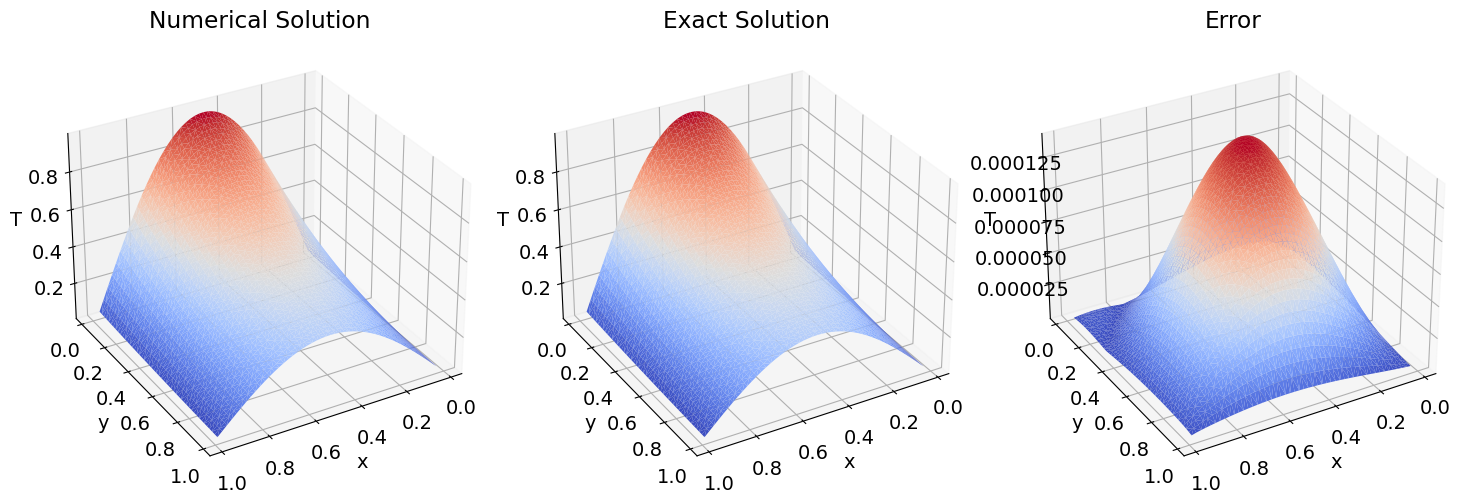

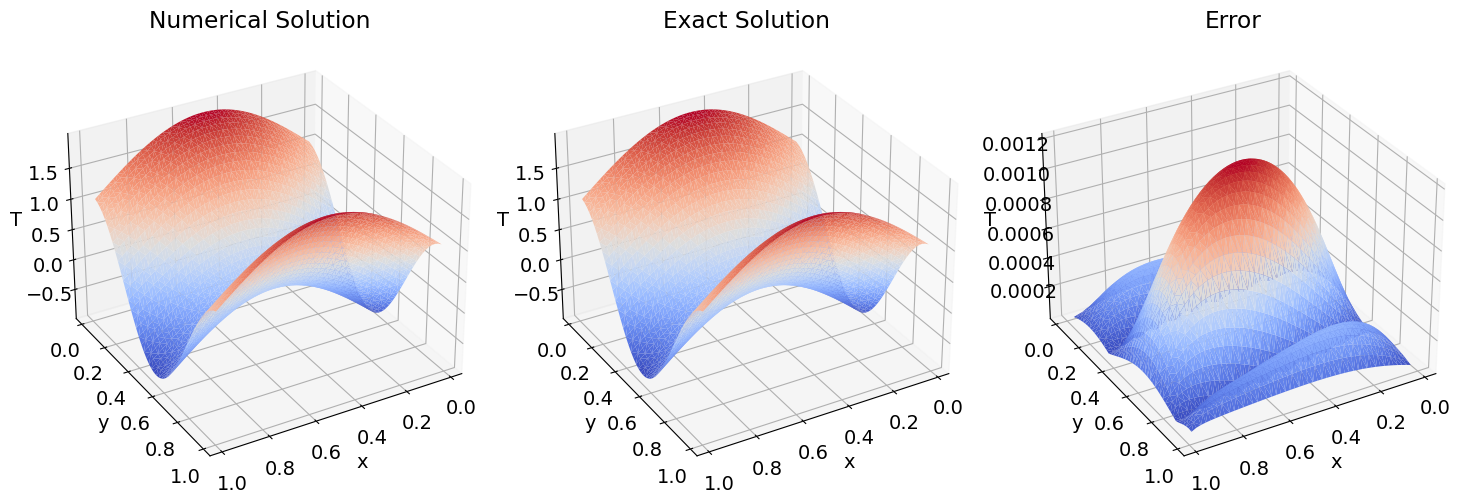

In [53]:
# Testing the function with the exact solution 1
U_cords, x_cords, y_cords = scheme1a(BVP(f=f1,g=g1,r=1,a=1,M=50,E=u1))
plot_comparison(U_cords, u1(x_cords,y_cords), x_cords, y_cords, viewAngle = 60)

U_cords, x_cords, y_cords = scheme1a(BVP(f=f2,g=g2,r=1,a=1,M=50,E=u2))
plot_comparison(U_cords, u2(x_cords,y_cords), x_cords, y_cords, viewAngle = 60)

## Task 1c)

,h,Error,Rate
0,0.20000,0.01455,0.00000
1,0.10000,0.00352,2.04544
2,0.06667,0.00156,2.01228
3,0.05000,0.00088,1.99757
4,0.04000,0.00056,1.99762
5,0.03333,0.00039,2.00035
6,0.02857,0.00029,2.00156
7,0.02500,0.00022,2.00211
8,0.02222,0.00017,2.00236
9,0.02000,0.00014,2.00038


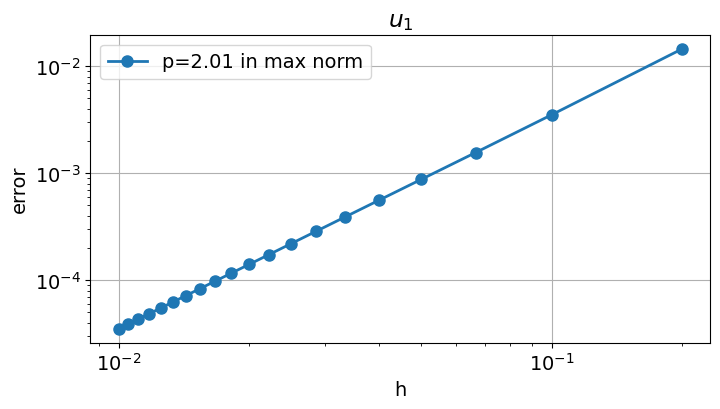

In [54]:
df = convergence(BVP(f=f1,g=g1,r=1,a=1,M=10,E=u1, T = "$u_1$"), scheme1a)
df

,h,Error,Rate
0,0.20000,0.11051,0.00000
1,0.10000,0.03080,1.84311
2,0.06667,0.01332,2.06798
3,0.05000,0.00759,1.95401
4,0.04000,0.00482,2.03516
5,0.03333,0.00336,1.97185
6,0.02857,0.00246,2.02390
7,0.02500,0.00189,1.97958
8,0.02222,0.00149,2.01814
9,0.02000,0.00121,1.98395


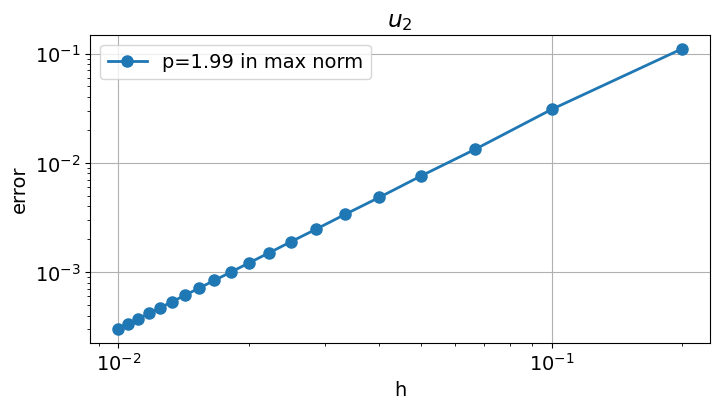

In [55]:
df = convergence(BVP(f=f2,g=g2,r=1,a=1,M=10,E=u2,T = "$u_2$"), scheme1a)
df

## Task 1d)

In [62]:
def scheme1d(BVP):
    start_func_time=time.time()

    h = 1/BVP.M
    k = abs(BVP.r)*h

    x_arr = np.linspace(0,1,BVP.M+1)
    y_arr = np.arange(0, 1, k)
    # y_arr = np.append(y_arr,1)
    y_arr = np.append(y_arr,y_arr[-1]+k)

    N = int(len(y_arr)-1)

    bndDist =  0 #y_arr[-1]-1

    X, Y = np.meshgrid(x_arr[1:-1],y_arr[1:-1])

    X_flat, Y_flat = X.flatten(), Y.flatten()

    # print(np.shape(X_flat), np.shape(Y_flat))
    X_flat_copy = np.copy(X_flat)
    Y_flat_copy = np.copy(Y_flat)
    
    dim = (BVP.M-1)*(N-1)
    f_vec = np.zeros(dim)
    g_vec = np.zeros(dim)

    f_vec += BVP.f(X_flat,Y_flat, BVP) 
    tol = 1e-10

    y_1_end = np.copy(y_arr)
    y_1_end[-1] = 1.0

    dim = (BVP.M-1)*(N-1)
    B = np.zeros((dim,dim))
    rPosOrNeg = BVP.r/abs(BVP.r)
    
    loop_start_time = time.time()
    for i, (X_flat,Y_flat) in enumerate(zip(X_flat,Y_flat)):

        B[i,i] = (2.0*BVP.a)/h**2 + 2.0/h**2
        
        # check if the stencil touches the left boundary
        if (math.isclose(X_flat-h,0., abs_tol = tol)):
            # print(f'the stencil tutches the left bnd-ry')
            
            B[i,i+1] = -1.0/h**2
            g_vec[i] += BVP.a*BVP.g(X_flat-h,Y_flat)/h**2 
            
            # check it the stencil touches also the lower boundary
            if (math.isclose(Y_flat-k,0., abs_tol = tol)): 
                # print(f'the stencil also tutches the lower bnd-ry')              
                g_vec[i] += BVP.g(X_flat-rPosOrNeg*h,Y_flat-k)/h**2
                if BVP.r < 0:
                    # the stencil tuches a total of 3 bnd'ry points
                    g_vec[i] += BVP.g(X_flat-h,Y_flat+k)/h**2
                else:
                    # the r > 0 => the stencil tuches two bnd'ry and two internal points
                    B[i,i+(BVP.M)] = -1.0/h**2
                            
            # check it the stencil touches also the upper boundary / overshoots the bnd'ry
            elif (math.isclose(Y_flat+k,y_arr[-1], abs_tol = tol)):                
                g_vec[i] += BVP.g(X_flat+rPosOrNeg*h,Y_flat+k-bndDist)/h**2
                if BVP.r < 0:
                    #  the stencil touches two bnd'ry and two internal points
                    g_vec[i] += BVP.g(X_flat-h,Y_flat+k-bndDist)/h**2
                    B[i,i+(BVP.M-2)] = -1.0/h**2
                else:
                    # the r > 0 => the stencil tuches a total of 3 bnd'ry points
                    g_vec[i] += BVP.g(X_flat-h,Y_flat-k)/h**2 
            
            # the stencil dont tuch the lower or upper bnd'ry
            else:
                g_vec[i] += BVP.g(X_flat-h,Y_flat-rPosOrNeg*k)/h**2 
                if BVP.r < 0:
                    #  the stencil tuches two bnd'ry and two internal points
                    # g_vec[i] += BVP.g(X_flat-h,Y_flat+k-bndDist)/h**2
                    B[i,i-(BVP.M-2)] = -1.0/h**2
                else:
                    # the r > 0 
                    B[i,i+(BVP.M)] = -1.0/h**2
                    # g_vec[i] += BVP.g(X_flat-h,Y_flat-rPosOrNeg*k)/h**2 

        # check if the stencil touches the right boundary
        elif (math.isclose(X_flat+h,1., abs_tol = tol)):
            # print(f'the stencil tutches the right bnd-ry')
            B[i,i-1] = -1.0/h**2
            g_vec[i] += BVP.a*BVP.g(X_flat+h,Y_flat)/h**2 # + BVP.g(X_flat+h,Y_flat+k)/h**2
                    
            # check it the stencil touches also the lower boundary
            if (math.isclose(Y_flat-k,0., abs_tol = tol)): 
                # print(f'the stencil also tutches the lower bnd-ry')               
                g_vec[i] += BVP.g(X_flat-rPosOrNeg*h,Y_flat-k)/h**2
                if BVP.r < 0:
                    # the stencil tuches a total of two bnd'ry and two internal points
                    B[i,i+(BVP.M-2)] = -1.0/h**2
                    # g_vec[i] += BVP.g(X_flat-h,Y_flat+k)/h**2
                else:
                    # the r > 0 => the stencil tuches tre3 bnd'ry  points
                    g_vec[i] += BVP.g(X_flat+h,Y_flat+k)/h**2
                            
            # check it the stencil touches also the upper boundary / overshoots the bnd'ry
            elif (math.isclose(Y_flat+k,y_arr[-1], abs_tol = tol)):                
                g_vec[i] += BVP.g(X_flat+rPosOrNeg*h,Y_flat+k-bndDist)/h**2
                if BVP.r < 0:
                    # the stencil tuches a total of 3 bnd'ry points
                    g_vec[i] += BVP.g(X_flat+h,Y_flat-k)/h**2
                    # B[i,i+(BVP.M-1)] = -1.0/h**2
                else:
                    # the r > 0 => the stencil tuches two bnd'ry and two internal points
                    B[i,i-(BVP.M)] = -1.0/h**2
                    
            else:
                g_vec[i] += BVP.g(X_flat+h,Y_flat+rPosOrNeg*k)/h**2 
                if BVP.r < 0:
                    #  the stencil tuches two bnd'ry and two internal points
                    # g_vec[i] += BVP.g(X_flat-h,Y_flat+k-bndDist)/h**2
                    B[i,i+(BVP.M-2)] = -1.0/h**2
                else:
                    # the r > 0 
                    B[i,i-(BVP.M)] = -1.0/h**2
                    # g_vec[i] += BVP.g(X_flat+h,Y_flat+rPosOrNeg*k)/h**2 
        
        # the stencil dont tuch the right or left bnd'ry
        else:  
            B[i,i+1] = -1.0/h**2
            B[i,i-1] = -1.0/h**2
            #check if the stencil touches the lower boundary
            if (math.isclose(Y_flat-k,0., abs_tol = tol)):
                # print(f'the stencil only tutches the lower bnd-ry')
                g_vec[i] += BVP.g(X_flat-rPosOrNeg*h,Y_flat-k)/h**2
                if BVP.r < 0:
                    B[i,i+(BVP.M-2)] = -1.0/h**2
                else:
                    B[i,i+(BVP.M)] = -1.0/h**2

            # check it the stencil touches also the upper boundary / overshoots the bnd'ry
            elif (math.isclose(Y_flat+k,y_arr[-1], abs_tol = tol)):
                # print(f'the stencil only tutches the upper bnd-ry')
                g_vec[i] += BVP.g(X_flat+rPosOrNeg*h,Y_flat+k-bndDist)/h**2
                if BVP.r < 0:
                    B[i,i-(BVP.M-2)] = -1.0/h**2
                else:
                    B[i,i-(BVP.M)] = -1.0/h**2
                
            else:
                # The stencil dont tuch any boundary points
                # print(f'the stencil tutches NO bnd-ry points')
                if BVP.r < 0:
                    B[i,i+(BVP.M-2)] = -1.0/h**2
                    B[i,i-(BVP.M-2)] = -1.0/h**2
                else:
                    B[i,i+(BVP.M)] = -1.0/h**2
                    B[i,i-(BVP.M)] = -1.0/h**2

            # print('\n')
                    
    loop_end_time = time.time()

    # Matrix_Plot(B*h**2)    
    
    U_P = np.linalg.solve(B, g_vec + f_vec)

    U_P = np.reshape(U_P,-1)
    end_func_time=time.time()
    # print(f'Loop duration: {(loop_end_time-loop_start_time):.5f} seconds')
    # print(f'Function duration: {(end_func_time - start_func_time):.5f} seconds')
    return U_P, X_flat_copy, Y_flat_copy

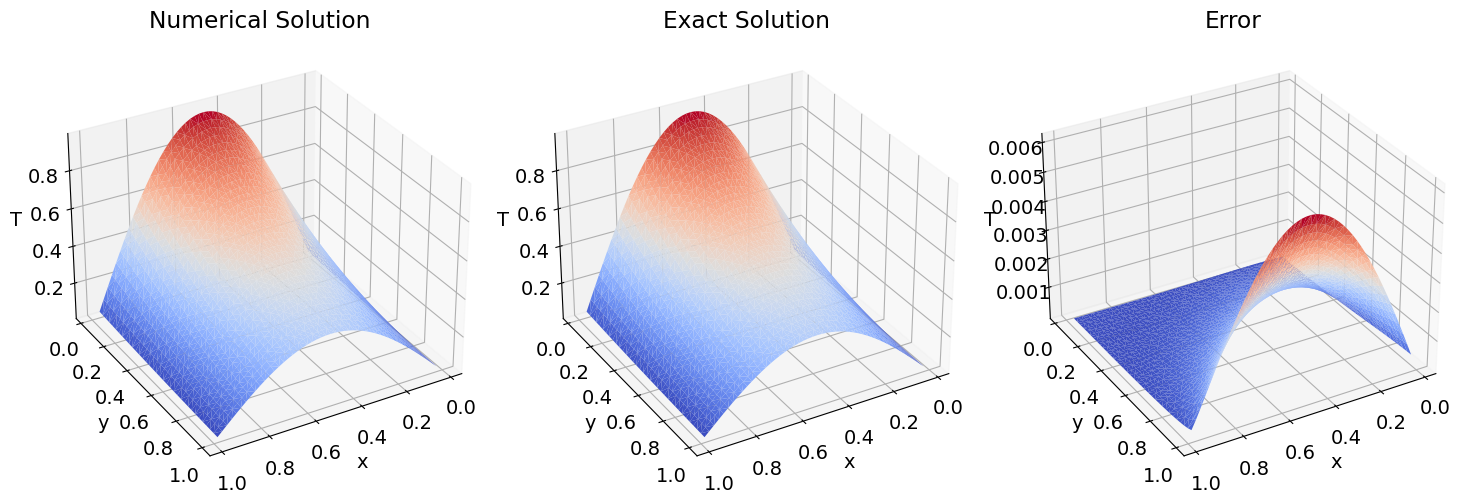

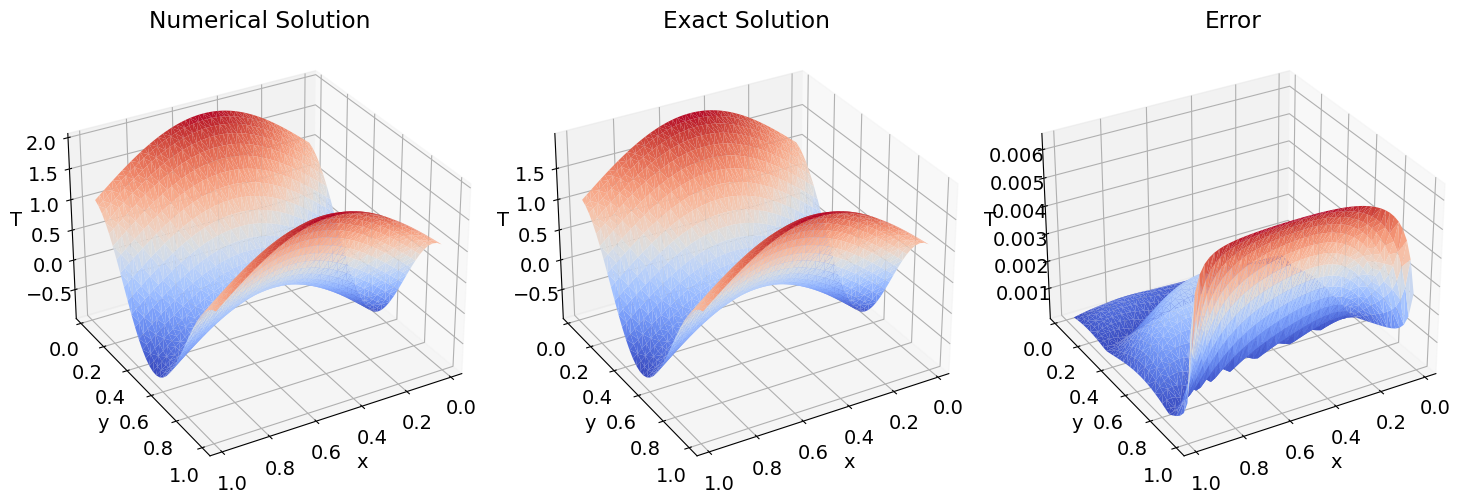

,h,Error,Rate
0,0.20000,0.02519,0.00000
1,0.10000,0.03120,-0.30851
2,0.06667,0.01060,2.66365
3,0.05000,0.01797,-1.83648
4,0.04000,0.00576,5.09798
5,0.03333,0.01183,-3.94630
6,0.02857,0.00335,8.17558
7,0.02500,0.00838,-6.85139
8,0.02222,0.00192,12.50673
9,0.02000,0.00617,-11.08141


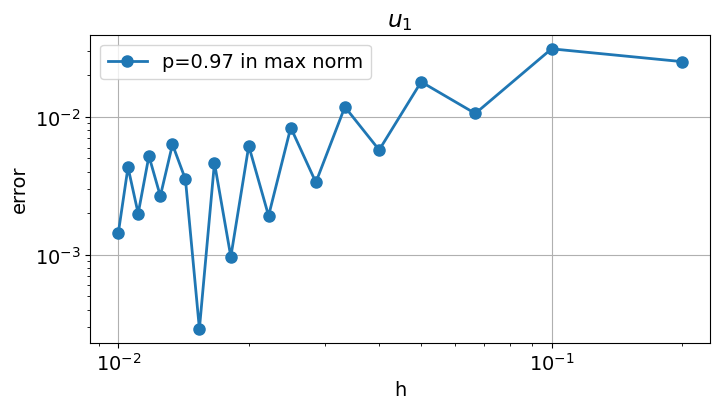

In [63]:
r = np.sqrt(2)
U_cords, x_cords, y_cords = scheme1d(BVP(f=f1,g=g1,r=r,a=1,M=50,E=u1))
plot_comparison(U_cords, u1(x_cords,y_cords), x_cords, y_cords, viewAngle = 60)

U_cords, x_cords, y_cords = scheme1d(BVP(f=f2,g=g2,r=r,a=1,M=50,E=u2))
plot_comparison(U_cords, u2(x_cords,y_cords), x_cords, y_cords, viewAngle = 60)
convergence(BVP(f=f1,g=g1,r=r,a=1,M=10,E=u1,T = "$u_1$"), scheme1d)
# convergence(BVP(f=f2,g=g2,r=r,a=1,M=10,E=u2,T = "$u_2$"), scheme1d)

# Task 2

In [58]:
def scheme2_projection(BVP):
    start_func_time=time.time()

    h = 1/BVP.M
    k = h
    x_arr = np.linspace(0,1,BVP.M+1)
    y_arr = np.linspace(0,1,BVP.M+1)

    X, Y = np.meshgrid(x_arr[1:-1],y_arr[1:-1])
    X_flat, Y_flat = X.flatten(), Y.flatten()

    # Itterates through the cords and removes all elements outside of the domain
    removal_list = []
    for i in range((BVP.M-1)**2):
        if X_flat[i] > (np.arccos(2*Y_flat[i]-1)/np.pi):
            removal_list.append(i)
    X_flat = np.delete(X_flat, removal_list)
    Y_flat = np.delete(Y_flat, removal_list)

    dim = len(X_flat)
    g_vec = np.zeros(dim)
    f_vec = np.zeros(dim)
    f_vec += BVP.f(X_flat,Y_flat, BVP) 

    tol = 1e-10
    X_flat_copy = np.copy(X_flat)
    Y_flat_copy = np.copy(Y_flat)

    B = np.zeros((dim,dim))

    loop_start_time = time.time()
    for i, (X_flat,Y_flat) in enumerate(zip(X_flat,Y_flat)):
        # print(f'Point i={i+1}')
        B[i,i] = 4.0/h**2

        # check if the stencil touches the left boundary
        if (math.isclose(X_flat-h,0., abs_tol = tol)):
            g_vec[i] += BVP.g(X_flat-h,Y_flat)/h**2 
            
            # check it the stencil touches also the lower boundary
            if (math.isclose(Y_flat-k,0., abs_tol = tol)):              
                g_vec[i] += BVP.g(X_flat,Y_flat-k)/h**2   
                B[i,i+1] = -1.0/h**2
                
                j = int(np.intersect1d(np.where((Y_flat+k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat+k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2
                            
            # check it the stencil North-point also overshoots the bnd'ry
            elif Y_flat+k >= 0.5*(np.cos(np.pi*X_flat)+1):
                g_vec[i] += BVP.g(X_flat,Y_flat+k)
                j = int(np.intersect1d(np.where((Y_flat-k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat-k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2
                #  the stencil overshoots in East point
                if X_flat+h >= (np.arccos(2*Y_flat-1)/np.pi):
                    g_vec[i] += BVP.g(X_flat+h,Y_flat)/h**2
                else:
                    B[i,i+1] = -1.0/h**2
            
            # the stencil dont tuch the lower or upper bnd'ry
            else:
                B[i,i+1] = -1.0/h**2
                j = int(np.intersect1d(np.where((Y_flat+k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat+k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2
                j = int(np.intersect1d(np.where((Y_flat-k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat-k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2
                    
        # check if the stencil overshooths the East point
        elif X_flat+h >= (np.arccos(2*Y_flat-1)/np.pi):
            B[i,i-1] = -1.0/h**2
            g_vec[i] += BVP.g(X_flat+h,Y_flat)/h**2
                    
            # check it the stencil touches also the lower boundary
            if (math.isclose(Y_flat-k,0., abs_tol = tol)):            
                g_vec[i] += BVP.g(X_flat,Y_flat-k)/h**2

                # check it the stencil North-point also overshoots the bnd'ry
                if Y_flat+k >= 0.5*(np.cos(np.pi*X_flat)+1):
                    g_vec[i] += BVP.g(X_flat,Y_flat+k)/h**2
                else:
                    j = int(np.intersect1d(np.where((Y_flat+k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat+k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                    B[i,j] = -1.0/h**2
            
            # check it the stencil North-point also overshoots the bnd'ry
            elif Y_flat+k >= 0.5*(np.cos(np.pi*X_flat)+1):             
                g_vec[i] += BVP.g(X_flat,Y_flat+k) 
                j = int(np.intersect1d(np.where((Y_flat-k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat-k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2
            # the stencil only overshoots the East point    
            else:
                j = int(np.intersect1d(np.where((Y_flat+k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat+k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2
                j = int(np.intersect1d(np.where((Y_flat-k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat-k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2

        # the stencil dont tuch the left bnd'ry or overshoots the East point
        else:  
            B[i,i+1] = -1.0/h**2
            B[i,i-1] = -1.0/h**2
            #check if the stencil touches the lower boundary
            if (math.isclose(Y_flat-k,0., abs_tol = tol)):
                g_vec[i] += BVP.g(X_flat,Y_flat-k)/h**2
                # check it the stencil North-point also overshoots the bnd'ry
                if Y_flat+k >= 0.5*(np.cos(np.pi*X_flat)+1):
                    g_vec[i] += BVP.g(X_flat,Y_flat+k)/h**2
                else:
                    j = int(np.intersect1d(np.where((Y_flat+k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat+k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                    B[i,j] = -1.0/h**2
            # check it the stencil North-point also overshoots the bnd'ry
            elif Y_flat+k >= 0.5*(np.cos(np.pi*X_flat)+1): 
                g_vec[i] += BVP.g(X_flat,Y_flat+k) 
                j = int(np.intersect1d(np.where((Y_flat-k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat-k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2
                
            # The stencil dont tuch any boundary points
            else:
                j = int(np.intersect1d(np.where((Y_flat+k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat+k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2
                j = int(np.intersect1d(np.where((Y_flat-k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat-k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2

                    
    loop_end_time = time.time()
    
    # Matrix_Plot(B*h**2)

    U_P = np.linalg.solve(B, g_vec + f_vec)

    U_P = np.reshape(U_P,-1)
    end_func_time=time.time()
    print(f'Loop duration: {(loop_end_time-loop_start_time):.5f} seconds')
    print(f'Function duration: {(end_func_time - start_func_time):.5f} seconds')
    return U_P, x_arr, y_arr, X_flat_copy, Y_flat_copy

In [59]:
def scheme2_mod_stencil(BVP):
    start_func_time=time.time()

    h = 1/BVP.M
    k = h
    x_arr = np.linspace(0,1,BVP.M+1)
    y_arr = np.linspace(0,1,BVP.M+1)

    X, Y = np.meshgrid(x_arr[1:-1],y_arr[1:-1])
    X_flat, Y_flat = X.flatten(), Y.flatten()

    # Itterates through the cords and removes all elements outside of the domain
    removal_list = []
    for i in range((BVP.M-1)**2):
        if X_flat[i] > (np.arccos(2*Y_flat[i]-1)/np.pi):
            removal_list.append(i)
    X_flat = np.delete(X_flat, removal_list)
    Y_flat = np.delete(Y_flat, removal_list)

    dim = len(X_flat)
    g_vec = np.zeros(dim)
    f_vec = np.zeros(dim)
    f_vec += BVP.f(X_flat,Y_flat, BVP) 

    tol = 1e-10
    # Make copy of the cords to return later
    X_flat_copy = np.copy(X_flat)
    Y_flat_copy = np.copy(Y_flat)

    # initilasing the Matrix
    B = np.zeros((dim,dim))

    loop_start_time = time.time()
    for i, (X_flat,Y_flat) in enumerate(zip(X_flat,Y_flat)):
        B[i,i] = 4.0/h**2
        # Define the scalar values for each point
        eta1 = h/((np.arccos(2*Y_flat-1))/(np.pi))
        aE_mark = (2)/(h**2 * eta1*(eta1+1))
        aW = (2)/(h**2 * (eta1+1))
        aP = (2)/(h**2 *eta1)
        eta2 = k/((np.cos(np.pi*X_flat)+1)/(2))
        bN_mark = (2)/(k**2 * eta2*(eta2+1))
        bS = (2)/(k**2 * (eta2+1))
        bP = (2)/(k**2 *eta2)

        # check if the stencil touches the left boundary
        if (math.isclose(X_flat-h,0., abs_tol = tol)):
            g_vec[i] += BVP.g(X_flat-h,Y_flat)/h**2 
            
            # check it the stencil touches also the lower boundary
            if (math.isclose(Y_flat-k,0., abs_tol = tol)):              
                g_vec[i] += BVP.g(X_flat,Y_flat-k)/h**2   
                B[i,i+1] = -1.0/h**2
                
                j = int(np.intersect1d(np.where((Y_flat+k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat+k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2
                            
            # check it the stencil North-point also overshoots the bnd'ry
            elif Y_flat+k >= 0.5*(np.cos(np.pi*X_flat)+1):

                g_vec[i] += bN_mark*BVP.g(X_flat,Y_flat+k)
                j = int(np.intersect1d(np.where((Y_flat-k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat-k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] =  -bS #-1.0/h**2
                #  the stencil overshoots in East point
                if X_flat+h >= (np.arccos(2*Y_flat-1)/np.pi):
                    g_vec[i] += aE_mark*BVP.g(X_flat+h,Y_flat)
                    g_vec[i] -= BVP.g(X_flat-h,Y_flat)/h**2 # Have to correct for the value priviusly added
                    g_vec[i] +=  aW*BVP.g(X_flat-h,Y_flat)
                    B[i,i] = aP + bP 
                else:
                    B[i,i] = 2.0/h**2 + bP
                    B[i,i+1] = -1.0/h**2
            
            # the stencil dont tuch the lower or upper bnd'ry
            else:
                B[i,i+1] = -1.0/h**2
                j = int(np.intersect1d(np.where((Y_flat+k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat+k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2
                j = int(np.intersect1d(np.where((Y_flat-k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat-k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2      

        # check if the stencil overshooths the East point
        elif X_flat+h >= (np.arccos(2*Y_flat-1)/np.pi):
            B[i,i-1] = -aW 
            g_vec[i] += aE_mark *BVP.g(X_flat+h,Y_flat) 
            B[i,i] = aP + 2.0/h**2      
            # check it the stencil touches also the lower boundary
            if (math.isclose(Y_flat-k,0., abs_tol = tol)):            
                g_vec[i] += BVP.g(X_flat,Y_flat-k)/h**2

                # check it the stencil North-point also overshoots the bnd'ry
                if Y_flat+k >= 0.5*(np.cos(np.pi*X_flat)+1):
                    g_vec[i] += bN_mark*BVP.g(X_flat,Y_flat+k) 
                    g_vec[i] -= BVP.g(X_flat,Y_flat-k)/h**2 # Have to correct for the value priviusly added
                    g_vec[i] += bS*BVP.g(X_flat,Y_flat-k)
                    B[i,i] = aP + bP
                else:
                    j = int(np.intersect1d(np.where((Y_flat+k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat+k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                    B[i,j] = -1.0/h**2
                    B[i,i] = aP + 2.0/h**2
            
            # check it the stencil North-point also overshoots the bnd'ry
            elif Y_flat+k >= 0.5*(np.cos(np.pi*X_flat)+1):             
                g_vec[i] += bN_mark*BVP.g(X_flat,Y_flat+k) 
                j = int(np.intersect1d(np.where((Y_flat-k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat-k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -bS 
                B[i,i] = aP + bP
            # the stencil only overshoots the East point    
            else:
                j = int(np.intersect1d(np.where((Y_flat+k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat+k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2
                j = int(np.intersect1d(np.where((Y_flat-k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat-k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2

        # the stencil dont tuch the left bnd'ry or overshoots the East point
        else:  
            B[i,i+1] = -1.0/h**2
            B[i,i-1] = -1.0/h**2
            #check if the stencil touches the lower boundary
            if (math.isclose(Y_flat-k,0., abs_tol = tol)):
                # check it the stencil North-point overshoots the bnd'ry
                if Y_flat+k >= 0.5*(np.cos(np.pi*X_flat)+1):
                    g_vec[i] += bS*BVP.g(X_flat,Y_flat-k)
                    g_vec[i] += bN_mark*BVP.g(X_flat,Y_flat+k) 
                    B[i,i] = 2.0/h**2 + bP
                else:
                    g_vec[i] += BVP.g(X_flat,Y_flat-k)/h**2
                    j = int(np.intersect1d(np.where((Y_flat+k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat+k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                    B[i,j] = -1.0/h**2
            # check it the stencil North-point overshoots the bnd'ry
            elif Y_flat+k >= 0.5*(np.cos(np.pi*X_flat)+1): 
                g_vec[i] += bN_mark*BVP.g(X_flat,Y_flat+k) 
                j = int(np.intersect1d(np.where((Y_flat-k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat-k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -bS
                B[i,i] = 2.0/h**2 + bP
                
            # The stencil dont tuch any boundary points
            else:
                j = int(np.intersect1d(np.where((Y_flat+k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat+k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2
                j = int(np.intersect1d(np.where((Y_flat-k-tol <= Y_flat_copy) & (Y_flat_copy <=  Y_flat-k+tol))
                                       , np.where((X_flat-tol <= X_flat_copy) & (X_flat_copy <= X_flat+tol)))[0])
                B[i,j] = -1.0/h**2

                    
    loop_end_time = time.time()
    
    # Matrix_Plot(B*h**2, cMap='tab20c')
    
    U_P = np.linalg.solve(B, g_vec + f_vec)

    U_P = np.reshape(U_P,-1)
    end_func_time=time.time()
    print(f'Loop duration: {(loop_end_time-loop_start_time):.5f} seconds')
    print(f'Function duration: {(end_func_time - start_func_time):.5f} seconds')
    return U_P, x_arr, y_arr, X_flat_copy, Y_flat_copy

Loop duration: 0.07973 seconds
Function duration: 0.11104 seconds


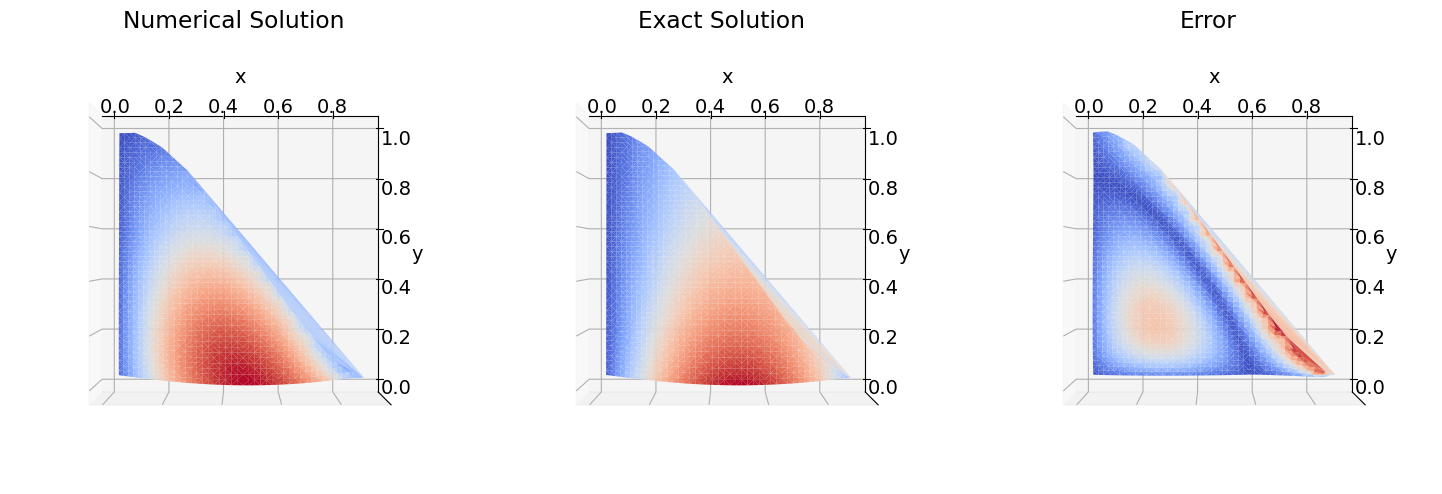

Loop duration: 0.13253 seconds
Function duration: 0.17478 seconds


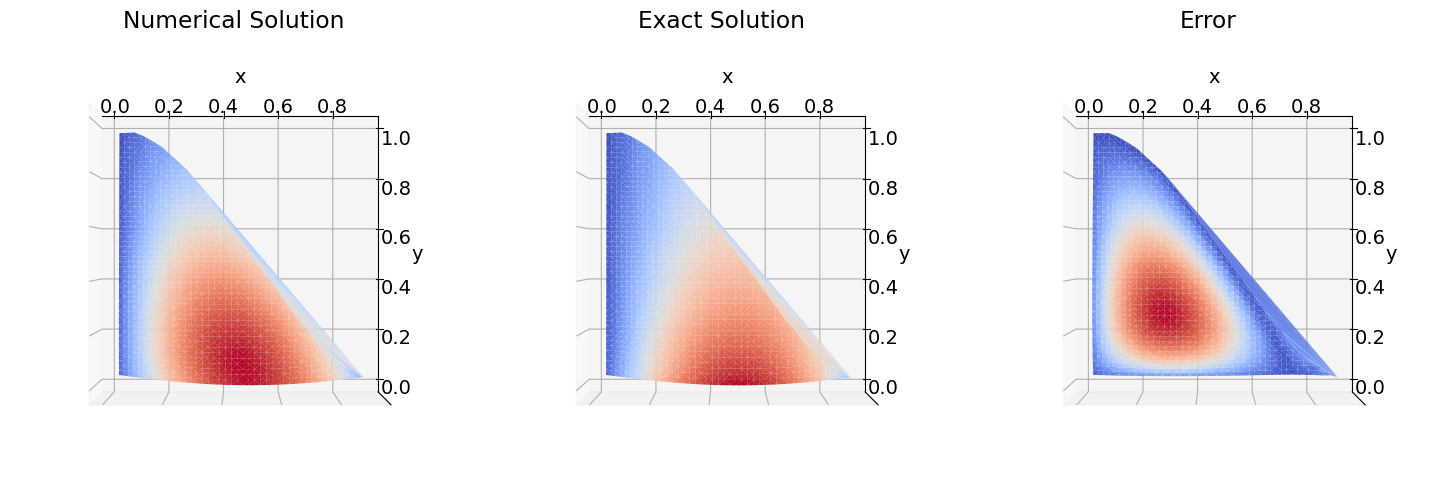

In [65]:
ex1 = BVP(f=f1,g=g1,M=51)
ex2 = BVP(f=f2,g=g2,M=51)

U_cords,x,y, x_cords, y_cords=scheme2_projection(ex1)
# plot_comparison(U_cords, u2(x_cords,y_cords), x_cords, y_cords, viewAngle = 60)
plot_comparison_2D(U_cords, u1(x_cords,y_cords), x_cords, y_cords, viewAngle = -90)

U_cords,x,y, x_cords, y_cords=scheme2_mod_stencil(ex1)
# plot_comparison(U_cords, u2(x_cords,y_cords), x_cords, y_cords, viewAngle = 60)
plot_comparison_2D(U_cords, u1(x_cords,y_cords), x_cords, y_cords, viewAngle = -90)
